# Klasifikacija teksta

Osim u obradi slika, konvolutivne neuronske mreže mogu se koristiti i u obradi teksta. Sledeći primer se odnosi na jednu takvu primenu u kojoj se 1D konvolutivne mreže koriste za klasifikaciju filmskih pregleda na pozitivne i negativne. 

 <img src='assets/1CovNets_for_NLP.png'>

U osnovi ovog pristupa je sledeća ideja. Pojedinačne reči teksta je potrebno prikazati kao vektore, a zatim konvolucijskim prozorima posmatrati njihove okoline. Na taj način može da se nauči o kontekstu pojave reči i njenoj semantici. Mi smo do sada videli već neke načine za predstavljanje reči, na primer, koristili smo Tf-Idf reprezentacije. U ovom primeru ćemo pustiti da sama mapira reči u vektore odgovarajućih dužina. Ta pojava se zove ugnježdavanje (engl. embedding).  

Prvo ćemo učitati sve neophodne biblioteke.

In [1]:
import sys
sys.path.append('..')
import matftorch

In [2]:
import torch
import torch.nn as nn

from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab

from collections import Counter
from collections import OrderedDict

from sklearn import model_selection



In [3]:
from matplotlib import pyplot as plt

In [4]:
import numpy as np
np.random.seed(7)

## Korak 1: Učitavanje skupa podataka

Za učitavanje podataka iskoristićemo podršku Keras biblioteke. Skup podataka sa kojim radimo se zove `imdb` i, kao što smo najavili, sadrži kolekciju filmskih pregleda. Prilikom učitavanja ovog skupa potrebno je da parametrom `max_features` navedemo koliko će najfrekventnijih reči vokabulara biti uzeto u obzir. Na nivou pojedinačnih pregleda će biti zadržane reči koje pripadaju ovom skupu, dok će preostale reči biti obrisane.

Mi ćemo se opredeliti za praćenje 2000 najfrekventnijih reči.

In [5]:
max_features = 2000 

In [6]:
train_iter, test_iter = IMDB(root='.')

In [7]:
for label, line in train_iter:
    print(label, line)
    break

1 I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, e

Svaku rečenicu iz skupa podataka ćemo predstaviti kao niz brojeva. Kako bi ovo uradili prvo je potrebno da pronađemo sve reči koje postoje u tekstu.

In [8]:
tokenizer = get_tokenizer('basic_english')
counter = Counter()
for label, line in train_iter:
    counter.update(tokenizer(line))

Nakon pronalaska svih reči napravićemo njihov rečnik

In [9]:
sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True) # sortiramo tokene po frekvenciji
ordered_dict = OrderedDict(sorted_by_freq_tuples)
recnik = vocab(ordered_dict, specials=['<unk>', '<pad>', '<bos>', '<eos>'], min_freq=400) # pravimo vocabular sa tokenima koji se pojavljuju barem 400 puta
print("Index of 'the':", recnik['the'])
print("Word corresponding to index 10:", recnik.get_itos()[10])

Index of 'the': 4
Word corresponding to index 10: to


In [10]:
def text_to_indices(recnik, texts):
    return [torch.tensor([recnik[token] if token in recnik else recnik['<unk>'] for token in tokenizer(text)]) for text in texts]

In [11]:
train_labels, train_texts = zip(*train_iter)
test_labels, test_texts = zip(*test_iter)
train_indices = text_to_indices(recnik, train_texts)
test_indices = text_to_indices(recnik, test_texts)

In [12]:
len(train_indices), len(test_indices)

(25000, 25000)

U skupu za treniranje, kao i u skupu za testiranje, imamo po 25000 pregleda.

## Korak 2: Priprema podataka

Da bismo sve preglede mogli da obrađujemo na isti način, moramo usaglasiti i njihove dužine. Mi ćemo se ograničiti na prvih 400 reči pregleda. Ukoliko je tekst duži od 400 reči, doći će do odsecanja sadržaja. Ukoliko je tekst kraći od 400 reči, dopunićemo ga nulama (podrazumevano se nule dodaju na početku sekvence). Funkcija koja ima ovo ponašanje i koju ćemo iskoristiti u radu je `pad_sequence` koja pripada skupu `keras.preprocessing`  funkcija za pripremu sekvencijalnih podataka.

In [13]:
max_len = 400

In [14]:
from torch.nn.utils.rnn import pad_sequence

train_indices_padded = pad_sequence(train_indices, batch_first=True)[:, :max_len]
test_indices_padded = pad_sequence(test_indices, batch_first=True)[:, :max_len]

In [15]:
train_indices_padded.shape

torch.Size([25000, 400])

U skupu ciljnih promenljivih imamo binarne vrednosti 0 i 1 koje redom predstavljuju negativne tj. pozitivno ocenjene preglede.

In [16]:
np.unique(train_labels)

array([1, 2])

Broj pozitivnih i broj negativnih pregleda je jednak.

In [17]:
np.bincount(train_labels)

array([    0, 12500, 12500])

## Korak 3: Pravljenje modela

Na početku naše mreže naći će se `Embedding` sloj. Ovaj sloj svakoj reči treba da pridruži vektorsku reprezentaciju dužine 128. Prvi argument sloja predstavlja veličinu vokabulara, drugi željenu dužinu ugnježdenih reprezentacija i treći maksimalnu dužinu pojedinačnih sekvenci. <img src='assets/embeddings.png'>



U ostatku mreže će se smenjivati 1D konvolutivni i 1D agregacioni slojevi uz izmenu da su korišćeni kerneli jednodimenzioni.  <img src='assets/1D_convolution_animated.gif'> 

Ako je veličina jednodimenzionog kernela $k$ to znači da će se posmatrati sekvence $k$ uzastopnih reči. Računica koja stoji iza ovakvog prolaza kernelom kroz ulazni tekst je prikazana na slici ispod. Ako se koristi $m$ filtera za uočenih $k$ uzastopnih reči kao izlaz možemo očekivati vektor dužine $m$.
<img src='assets/1D_convolution_with_math.png'>

Na slici ispod možemo videti i kako izgleda operacija agregacije za jednodimenzioni slučaj. 
<img src='assets/1D_pooling.png'>


Na kraju mreže će se naći gusti sloj sa jednim neuronom i sigmoidnom aktivacijom koji će omogućiti binarni izlaz. 

In [18]:
class IMDbModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(IMDbModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = nn.Conv1d(embedding_dim, 32, kernel_size=7)
        self.pool1 = nn.MaxPool1d(5)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=7)
        self.pool2 = nn.MaxPool1d(5)
        self.global_pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)  # Conv1d expects input in the format (batch_size, embedding_dim, seq_len)
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.pool2(x)
        x = self.global_pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x
model = IMDbModel(len(recnik), 128)

In [19]:
model

IMDbModel(
  (embedding): Embedding(1364, 128)
  (conv1): Conv1d(128, 32, kernel_size=(7,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(7,), stride=(1,))
  (pool2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (global_pool): AdaptiveMaxPool1d(output_size=1)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

Kao funkciju greške koristićemo binarnu unakrsnu entropiju, a kao optimizator Adam. 

Mrežu ćemo trenirati u 10 epoha, koristeći paketiće veličine 128 instanci. Uspešnost treniranja pratićemo na validacionom skupu veličine 20% ukupnog skupa podataka. Treniranje će malo potrajati.

In [ ]:
epochs = 10
batch_size = 128
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(train_indices_padded, torch.tensor(train_labels), test_size=0.2, random_state=42, stratify=train_labels)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(list(zip(X_valid, y_valid)), batch_size=batch_size)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_losses, train_accuracies, val_losses, val_accuracies = matftorch.train_classification(model, criterion, optimizer, epochs, train_loader, valid_loader)

Sam tok treniranja mreže možemo ispratiti grafički.

NameError: name 'epochs' is not defined

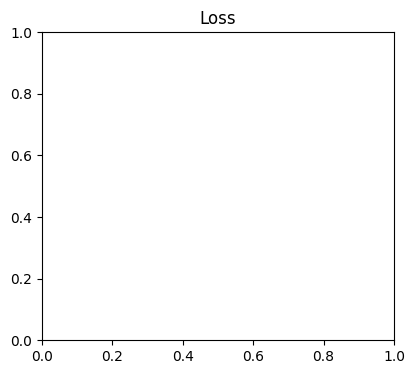

In [25]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(0, epochs), train_losses, label='train')
plt.plot(np.arange(0, epochs), val_losses, label='val')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(0, epochs), train_accuracies, label='train')
plt.plot(np.arange(0, epochs), val_accuracies, label='val')
plt.legend(loc='best')

plt.show()

Sa ovih grafikona možemo primetiti da se posle četvrte epohe model preprilagođava podacima i da ima smisla dodati regularizaciju u vidu `dropout` sloja.

## Korak 4: Evaluacija modela

Mrežu ćemo evaluirati na skupu za testiranje.

In [ ]:
X_test = test_indices_padded
y_test = torch.tensor(test_labels)
model.eval()
test_loader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), batch_size=batch_size)

score = matftorch.test_classification(model, criterion, test_loader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.358565092086792
Test accuracy: 0.8410400152206421


S obzirom da smo u učenju koristili svega 2000 reči ima smisla probati kako se model ponaša ukoliko se radi sa većim vokabularom. Takođe, ima smisla probati i sa nešto drugačijim ugnježđenim reprezentacijama, na primer, nešto kraćim. Ove zadatke ostavljamo za vežbu.

Možemo još testirati kako se naš model ponaša za novi pregled.

In [ ]:
new_review = "this is super interesting and funny movie"

In [ ]:
word_index = recnik.get_stoi()

In [ ]:
new_review_in_indexes = [word_index[word] for word in new_review.split(' ')]

In [ ]:
new_review_in_indexes

[11, 6, 1162, 218, 2, 160, 17]

In [ ]:

new_review_tensor = torch.tensor(new_review_in_indexes)
padded_sequence = pad_sequence([new_review_tensor], batch_first=True, padding_value=0, total_length=max_len)

In [ ]:
padded_sequence

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [ ]:
score = model(padded_sequence)

In [ ]:
score

array([0.5218582], dtype=float32)

In [ ]:
new_class = int(score>0.5)

In [ ]:
new_class

1

## Korak 5: Čuvanje modela

Čuvanje Keras modela obuhvata čuvanje informacija o arhitekturi, parametrima, konfiguraciju treniranja i stanja optimizatora tako da se nesmetano može nastaviti sa radom nakon njegovog ponovnog učitavanja. Modeli se čuvaju u HDF5 formatu koji se koristi za čuvanje velikih količina numeričkih podataka. Za izdvajanje informacija iz ovakvih datoteka možemo koristiti funkcionalnosti biblioteke h5py. Nju možemo instalirati komandom `conda install -c anaconda h5py` u skladu sa [zvaničnim smernicama](https://anaconda.org/anaconda/h5py). Više o samoj biblioteci može se pronaći i na [zvaničnoj stranici](https://www.h5py.org/). 

Mi ćemo u radu koristiti Keras podršku dostupnu kroz `load_model` funkcionalnosti. Funkcijom `save` se čuva model, a funkcijom `load_model` učitava postojeći. 

Čuvanje modela može biti naročito važno ukoliko je za njegovo treniranje potrebno puno resursa i vremena. 

In [ ]:
torch.save(model, 'models/model.pth')


model.load_state_dict(torch.load('models/model.pth'))

<div class='alert alert-info'>
    Za dalje istraživanje: 
    <a href='https://lena-voita.github.io/nlp_course/models/convolutional.html'> Convolutional Neural Networks for Text </a>
</div>